<i>## Comments will be provided using this format. Key takeaway: groups are encouraged to change the formatting, but not the structure. Groups are also allowed to create additional notebooks - for instance, create one notebook for data exploration, and one notebook for each preprocessing-modelling-evaluation pipeline -, but must strive to keep an unified style across notebooks.</i>

#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Notebook Title`

#### Group:
- `Group member #1`
- `(...)`
- `Group member #5`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Understanding](#P1)
- [2. General Data Preparation](#P2) 
- [3. Multilabel Classification (Information Requirement 3311)](#P3)
    - [3.1 Specific Data Preparation](#P31)
    - [3.2 Model Implementation](#P32)
    - [3.3 Model Evaluation](#P3n)
- [4. Sentiment Analysis (Information Requirement 3312)](#P4)
    - [4.1 Specific Data Preparation](#P41)
    - [4.2 Model Implementation](#P42)
    - [4.3 Model Evaluation](#P43)
- [...]
- [N. Additional Tasks (Information Requirements 332n)](#Pn)
    - [N.1 Specific Data Preparation](#Pn1)
    - [N.2 Model Implementation](#Pn2)
    - [N.3 Model Evaluation](#Pn3)

<i>## Note that the notebook structure differs from the report: instead of following the CRISP-DM phases and then specifying the different problems inside the phases, the notebook is structured by problem, with the CRISP-DM phases being defined for each specific problem.

In [109]:
%reload_ext autoreload
%autoreload 2

In [113]:
## All imports must be concentrated on a cell that immediately follow the table of contents
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

#without truncation
pd.set_option('display.max_colwidth', None)

<font color='#BFD72F' size=5>1. Data Understanding</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

<i>## Imports.</i>

In [66]:
reviews=pd.read_csv('data/reviews_initial_preproc.csv')
restaurants=pd.read_csv('data/restaurants_initial_preproc.csv') 
restaurants['Collections'].fillna('[]', inplace=True)
restaurants['Collections'] = restaurants['Collections'].apply(lambda x: eval(x))
restaurants['Cuisines'] = restaurants['Cuisines'].apply(lambda x: eval(x))

## Restaurant data exploration


In [70]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           105 non-null    object
 1   Cost           105 non-null    int64 
 2   Collections    105 non-null    object
 3   Cuisines       105 non-null    object
 4   N_collections  105 non-null    int64 
 5   open time      105 non-null    int64 
 6   closing time   105 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 5.9+ KB


In [71]:
restaurants.describe()

,Cost,N_collections,open time,closing time
count,105.000000,105.000000,105.000000,105.000000
mean,861.428571,1.009524,11.028571,18.971429
std,510.149730,1.451095,2.826581,8.471056
min,150.000000,0.000000,1.000000,1.000000
25%,500.000000,0.000000,11.000000,22.000000
50%,700.000000,0.000000,12.000000,23.000000
75%,1200.000000,1.000000,12.000000,23.000000
max,2800.000000,7.000000,24.000000,24.000000


In [72]:
#there is no restaunt duplicates
restaurants['Name'].nunique()

105

In [73]:
cuisines_exploded = restaurants['Cuisines'].explode().explode()
collections_exploded = restaurants['Collections'].explode().explode()

In [74]:
"""restaurant_agg = restaurants_exploded.groupby(['Cuisines', 'Collections']).agg(
    total_cost=('Cost', 'mean'), # Sum of 'Cost'
    count=('Cost', 'count')     # Count of restaurants
)

# Sort the result by 'total_cost' in descending order and get the top 10 rows
restaurant_agg.sort_values(by='total_cost', ascending=False).head(10)"""

"restaurant_agg = restaurants_exploded.groupby(['Cuisines', 'Collections']).agg(\n    total_cost=('Cost', 'mean'), # Sum of 'Cost'\n    count=('Cost', 'count')     # Count of restaurants\n)\n\n# Sort the result by 'total_cost' in descending order and get the top 10 rows\nrestaurant_agg.sort_values(by='total_cost', ascending=False).head(10)"

In [75]:
"""restaurants_exploded.groupby(['Collections']).agg(
    mean_cost=('Cost', 'mean'),   # Calculate the mean of 'Cost'
    count=('Cost', 'count') ).sort_values(by='mean_cost', ascending=False).head(5)"""

"restaurants_exploded.groupby(['Collections']).agg(\n    mean_cost=('Cost', 'mean'),   # Calculate the mean of 'Cost'\n    count=('Cost', 'count') ).sort_values(by='mean_cost', ascending=False).head(5)"

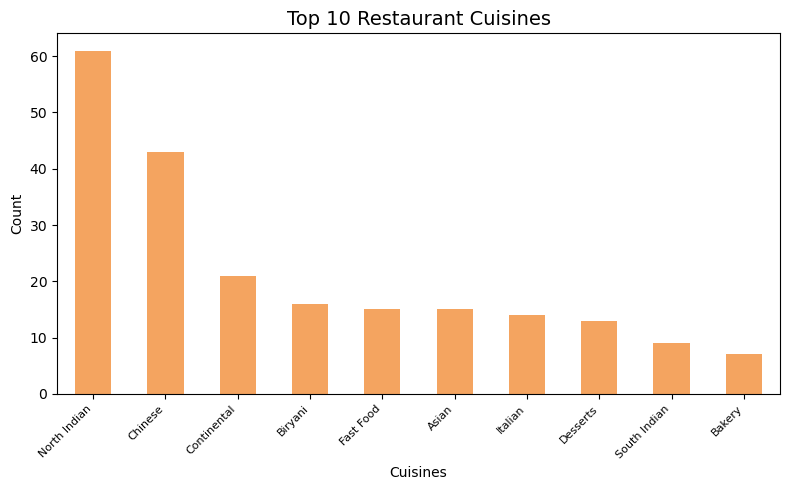

In [76]:
plot_top10_bar(cuisines_exploded)

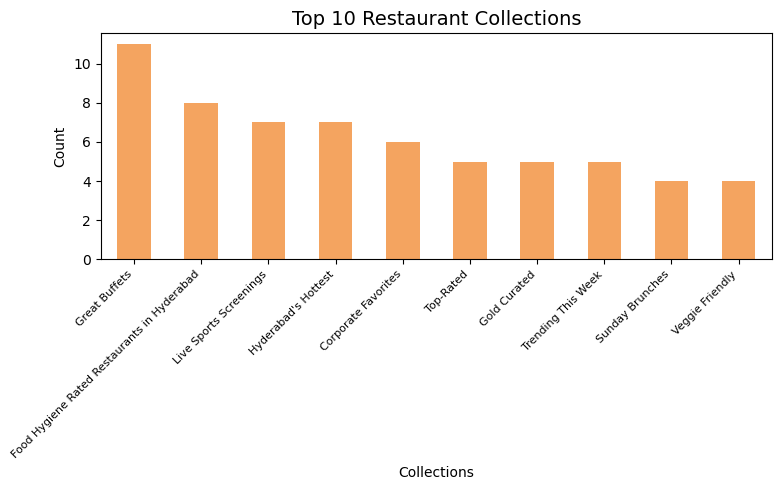

In [77]:
plot_top10_bar(collections_exploded)

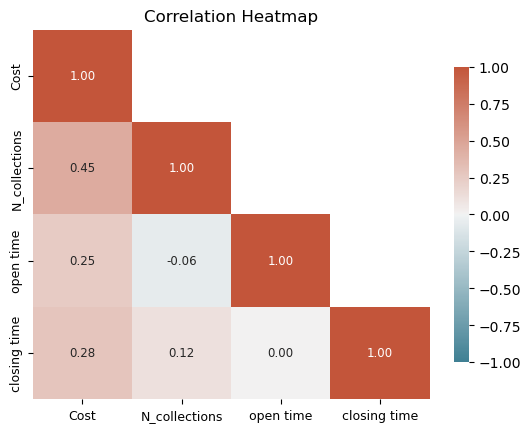

In [134]:
plot_heatmap(restaurants)

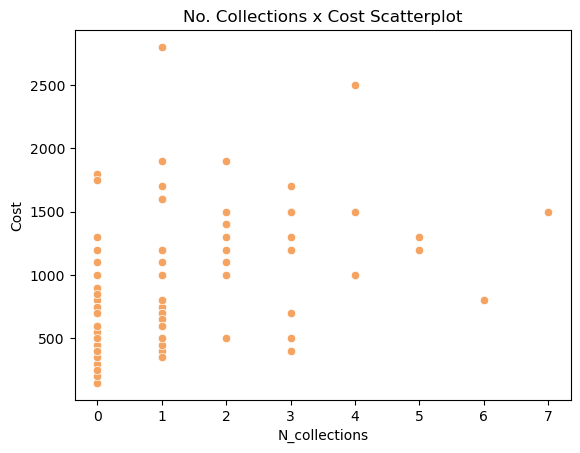

In [79]:
sns.scatterplot(restaurants, x='N_collections', y='Cost', c='sandybrown').set_title('No. Collections x Cost Scatterplot')
plt.show()

## Reviews data exploration

In [80]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9962 entries, 0 to 9961
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  9962 non-null   object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   float64
 4   Time        9962 non-null   object 
 5   Pictures    9962 non-null   int64  
 6   N_reviews   9956 non-null   float64
 7   Followers   8384 non-null   float64
 8   Month       9962 non-null   int64  
 9   Year        9962 non-null   int64  
 10  Weekend     9962 non-null   int64  
 11  Post_Meal   9962 non-null   int64  
 12  msg_len     9962 non-null   int64  
 13  nr_sents    9962 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.1+ MB


In [81]:
reviews.describe()

,Rating,Pictures,N_reviews,Followers,Month,Year,Weekend,Post_Meal,msg_len,nr_sents
count,9962.000000,9962.000000,9956.000000,8384.000000,9962.000000,9962.000000,9962.000000,9962.000000,9962.000000,9962.000000
mean,3.601185,0.751456,23.959321,193.672233,6.017868,2018.452118,0.357759,0.538446,281.262899,4.065248
std,1.483453,2.574863,50.601613,671.374116,3.159464,0.562494,0.479365,0.498545,341.581888,4.235389
min,1.000000,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,0.000000,1.000000,2.000000,4.000000,2018.000000,0.000000,0.000000,145.000000,1.000000
50%,4.000000,0.000000,4.000000,13.000000,5.000000,2018.000000,0.000000,1.000000,190.000000,3.000000
75%,5.000000,0.000000,22.000000,92.000000,8.000000,2019.000000,1.000000,1.000000,323.000000,5.000000
max,5.000000,64.000000,1031.000000,13410.000000,12.000000,2019.000000,1.000000,1.000000,5247.000000,66.000000


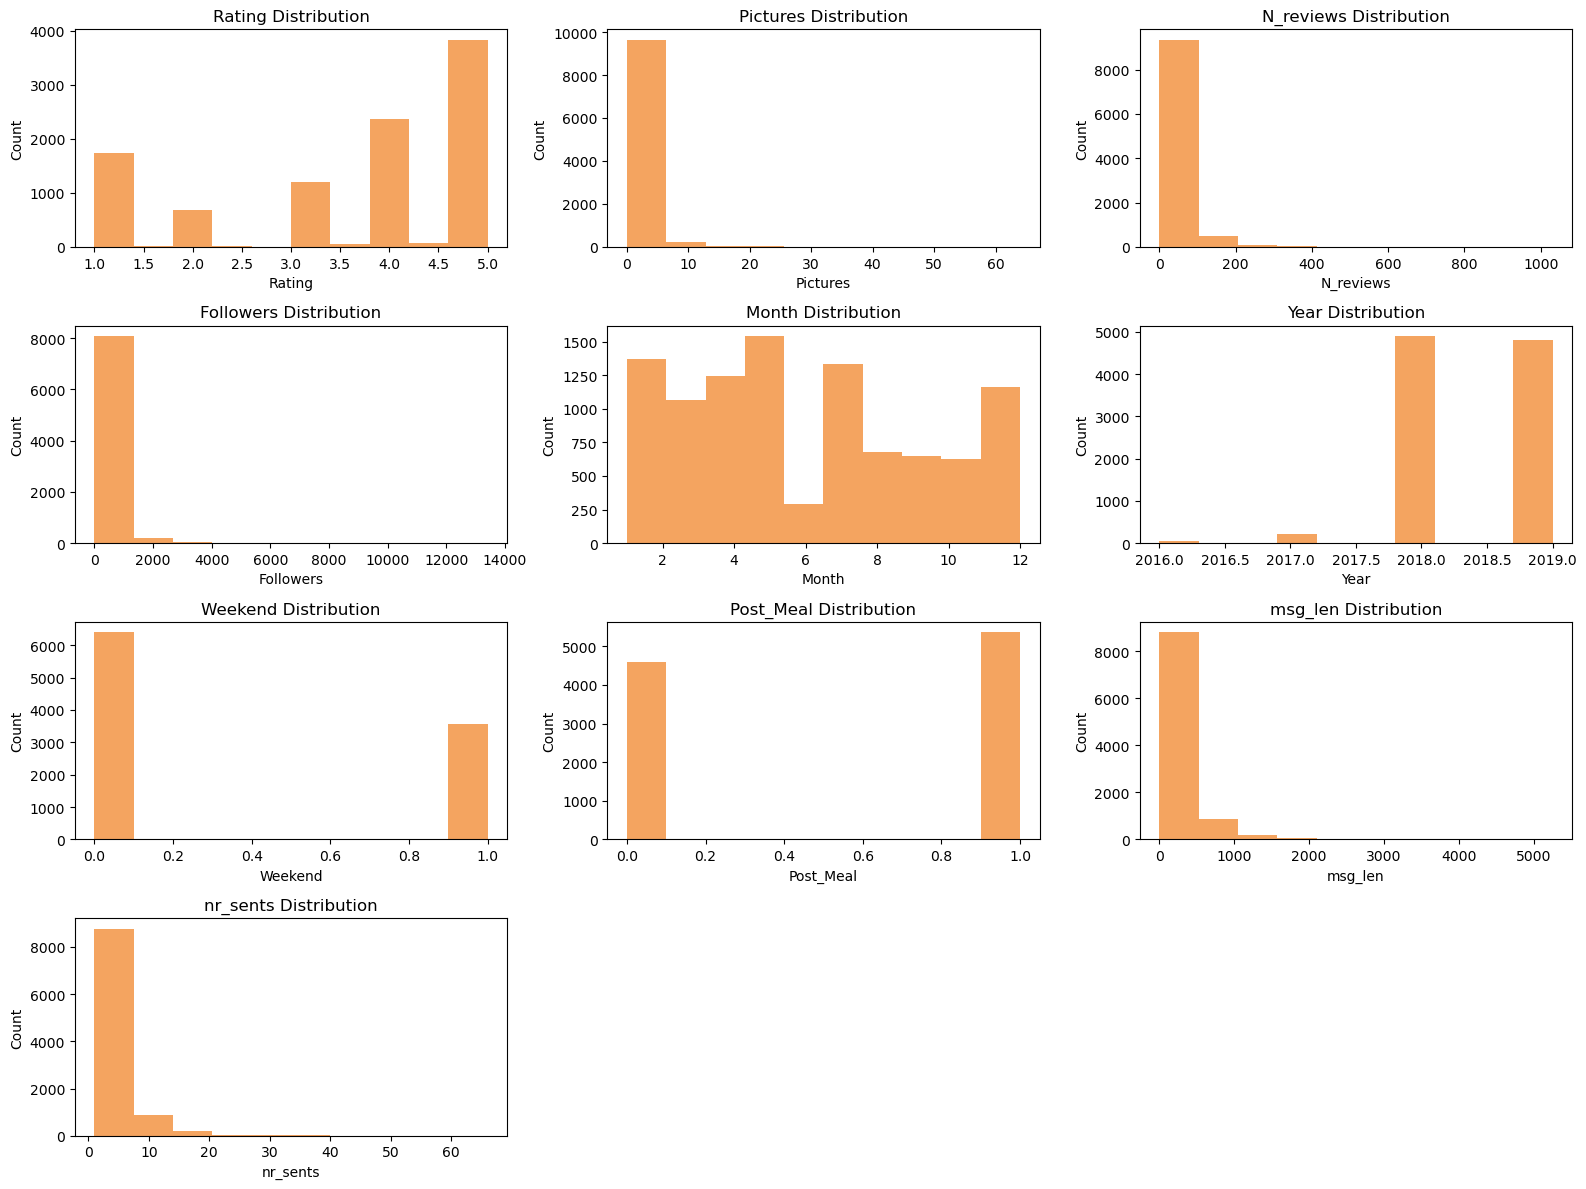

In [84]:
plot_histograms(reviews, ['Rating','Pictures','N_reviews','Followers','Month','Year','Weekend','Post_Meal','msg_len','nr_sents'])

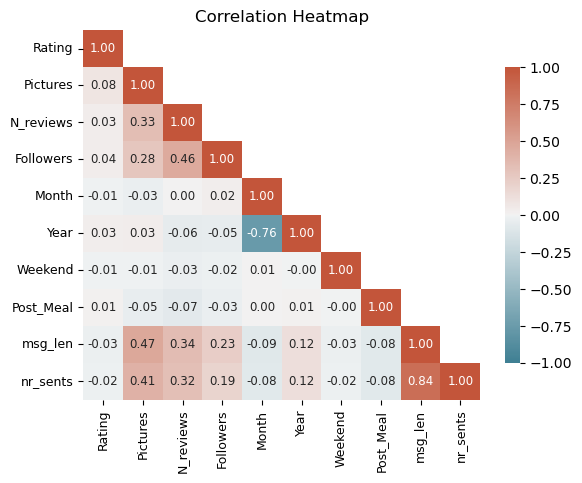

In [133]:
plot_heatmap(reviews)

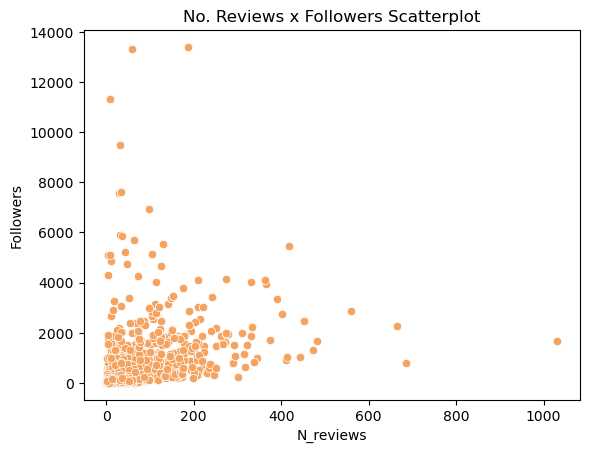

In [64]:
sns.scatterplot(reviews, x='N_reviews', y='Followers', c='sandybrown').set_title('No. Reviews x Followers Scatterplot')
plt.show()

In [136]:
print('Top Reviewers')
reviews['Reviewer'].value_counts().sort_values(ascending=False)

Top Reviewers


Parijat Ray              13
Ankita                   13
Kiran                    12
Vedant Killa             11
Jay Mehta                11
                         ..
Manish Singh              1
Kshitiz Goyal             1
Deepali K. Nagrani        1
Laxminarayana Amuraji     1
Bhargava Krishna          1
Name: Reviewer, Length: 7446, dtype: int64

In [137]:
print('How many reviews each restaurant has')
reviews['Restaurant'].value_counts().sort_values(ascending=True)

How many reviews each restaurant has


American Wild Wings                 77
Arena Eleven                        85
Behrouz Biryani                    100
Over The Moon Brew Company         100
The Fisherman's Wharf              100
                                  ... 
Zega - Sheraton Hyderabad Hotel    100
Triptify                           100
Royal Spicy Restaurant             100
Faasos                             100
Gal Punjab Di                      100
Name: Restaurant, Length: 100, dtype: int64

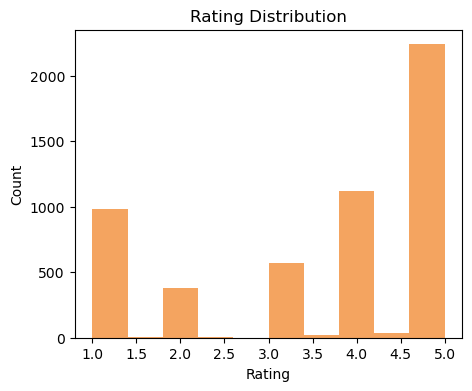

In [151]:
fig, ax = plt.subplots(figsize=(5,4))
plot_histogram(ax=ax, df=reviews[reviews['Post_Meal']==1], column='Rating')
plt.show()

Das pessoas que enviaram review logo a seguir a refeição, maioria atribuiu rating the 5 (very good, very nice)

See if a reviewer has given more than one review to the same restaurant.

In [152]:
review_counts = reviews.groupby(['Reviewer', 'Restaurant']).agg(
    mean_rating=('Rating','mean'),
    review_count=('Rating','count')).sort_values(by='review_count', ascending=False)

review_counts[review_counts['review_count'] > 1]

,,mean_rating,review_count
Reviewer,Restaurant,,
Afreen Jahan,eat.fit,3.833333,6
Malar Madhav Rao,Domino's Pizza,1.250000,4
Rahul Nayak,Amul,5.000000,4
Rahul Jaiswal,Pakwaan Grand,2.750000,4
Prite,Being Hungry,5.000000,4
...,...,...,...
Rakesh Raja,Being Hungry,5.000000,2
Ramyasree A,Hunger Maggi Point,2.500000,2
Yugandhar,Cream Stone,4.000000,2
